# Microservice in Lambda using API Gateway ☁ (Serverless API)

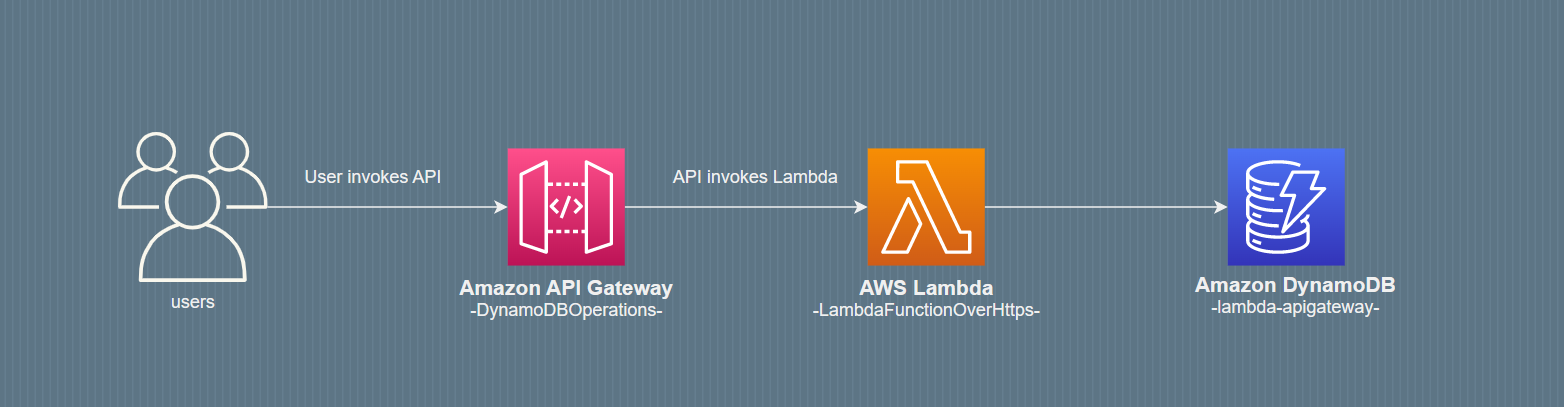
> the lambda shall contain logic for CRUD operations on DynamoDB Table

An __Amazon API Gateway__ is a collection of resources and methods.

For this tutorial, you create one resource(DynamoDBManager) and define one method (POST) on it.

The method is backed by Lambda function (LambdaFunctionOverHttps).

That is, 
swhen you call the API through an Https endpoint, Amazon API Gateway invokes the Lambda function.

The POST method on the DynamoDBManager resource supports the following DynamoDB operations:
>   - Create, read, update and delete an item
>   - Scan items
>   - Other operation for e.g. echo, ping. That are not related to DynamoDB that you can use for testing.
    
The request payload you send in the POST request identifies the DynamoDB operation and provides neccessary data.
    For e.g.
   

> this is a sample request payload for a DynamoDB __create item__ operation:

```python
 {
     "operation": "create",
     "tableName": "lambda-apigateway",
     "payload": {
         "Item": {
             "id": "1",
             "name": "Bob"
         }
     } 
 } 
```

> this a sample request payload for a Dynamo __read item__ operation:

```python
 {
     "operation": "read",
     "tableName": "lambda-apigateway",
     "payload": {
          "Key": {
             "id":"1"
           }
     }         
 }
```

## Setup

### Create Lambda IAM Role 

Create the execution role that gives your function permission to access AWS resources.
To create an execution role

    1. Open the roles page in the IAM Console.
    
    2. Choose "Create role".
    
    3. Create a role with the following properties.
        - Trusted entity type : AWS service 
        - Use Case : Lambda


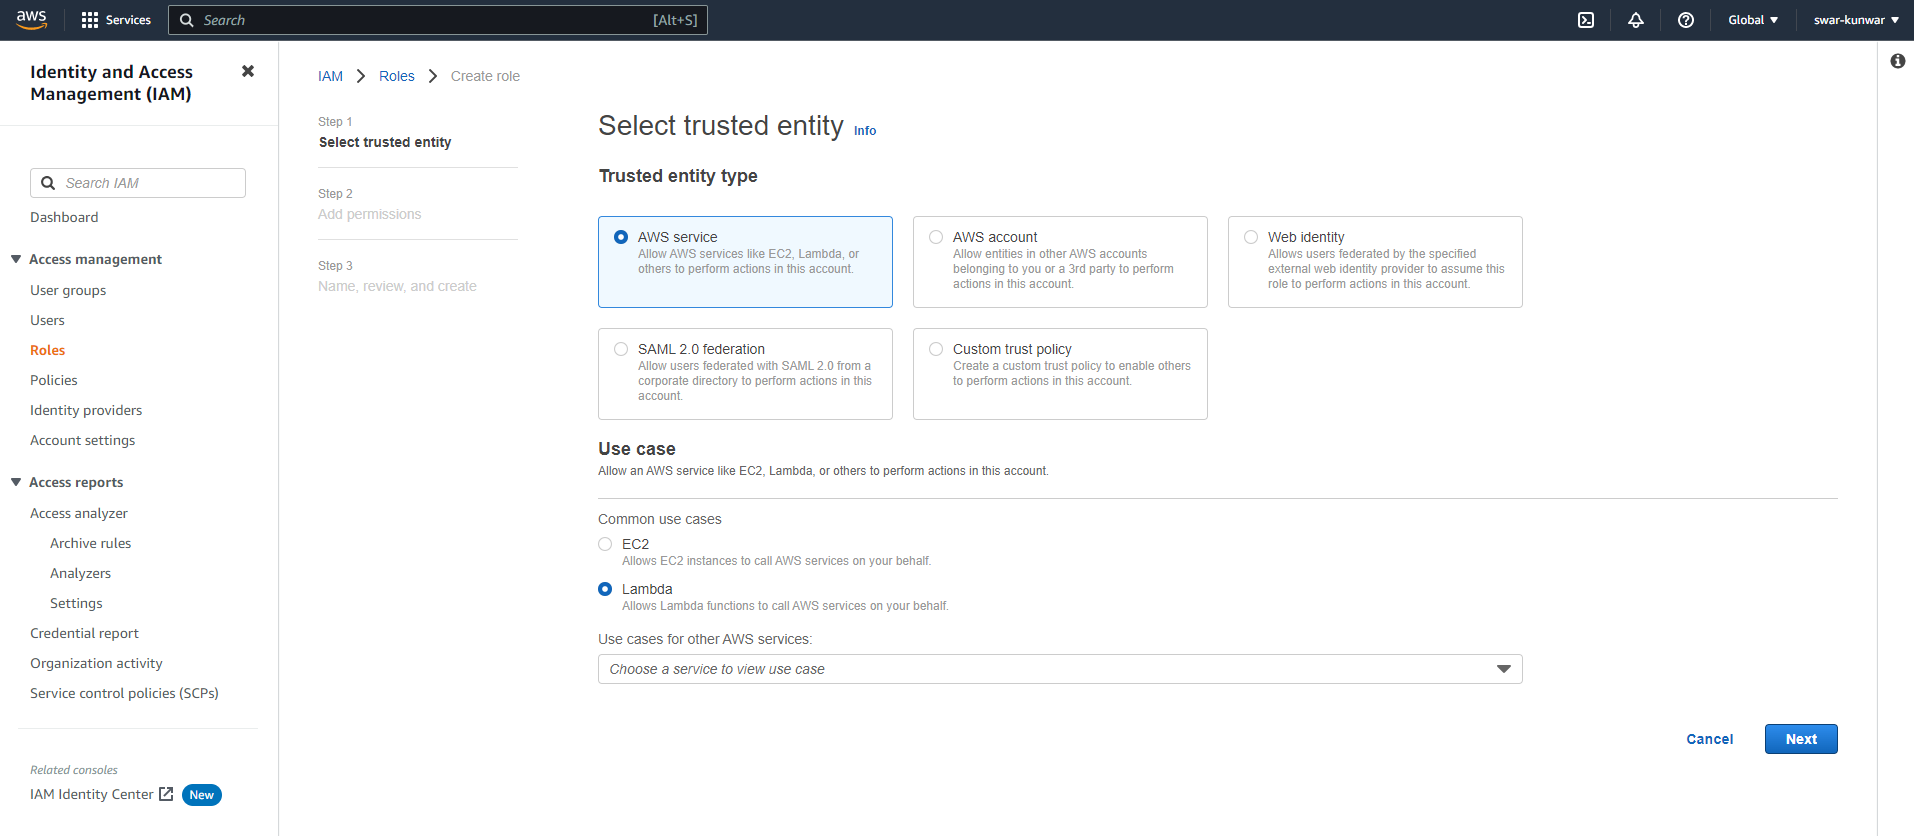
    


    4. The IAM console will ask you to "Add Permission", create a new custom policy using JSON as follows.

> this custom policy has the permissions that the function needs to write data to DynamoDB and upload logs.
    
    
```python   
 {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "1",
            "Action": [
                "dynamodb:DeleteItem",
                "dynamodb:GetItem",
                "dynamodb:PutItem",
                "dynamodb:Query",
                "dynamodb:Scan",
                "dynamodb:UpdateItem"
                ],
            "Effect": "Allow",
            "Resource": "*"
        },
        {
            "Sid": "2",
            "Resource": "*",
            "Action" : [
                "logs:CreateLogGroup",
                "logs:CreateLogStream",
                "logs:PutLogEvents"
                ],
            "Effect": "Allow"
        }
        ]
}
```         

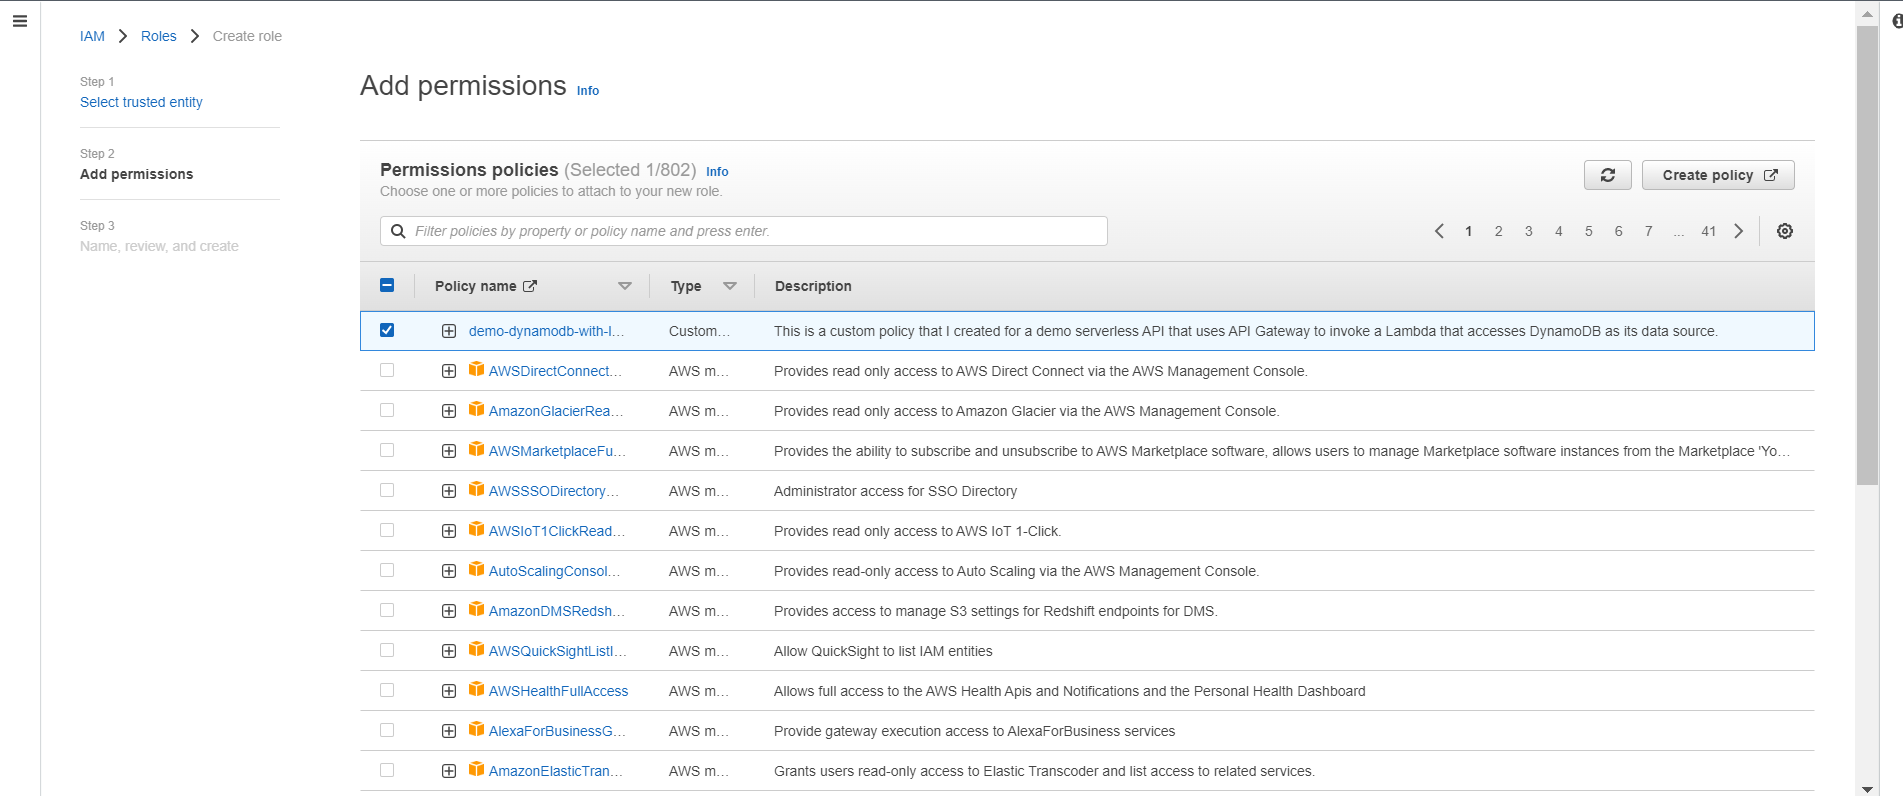

    - Permissions : demo-dynamodb-with-logs-policy   ( Custom policy with permission to DynamoDB and CloudWatch Logs. )

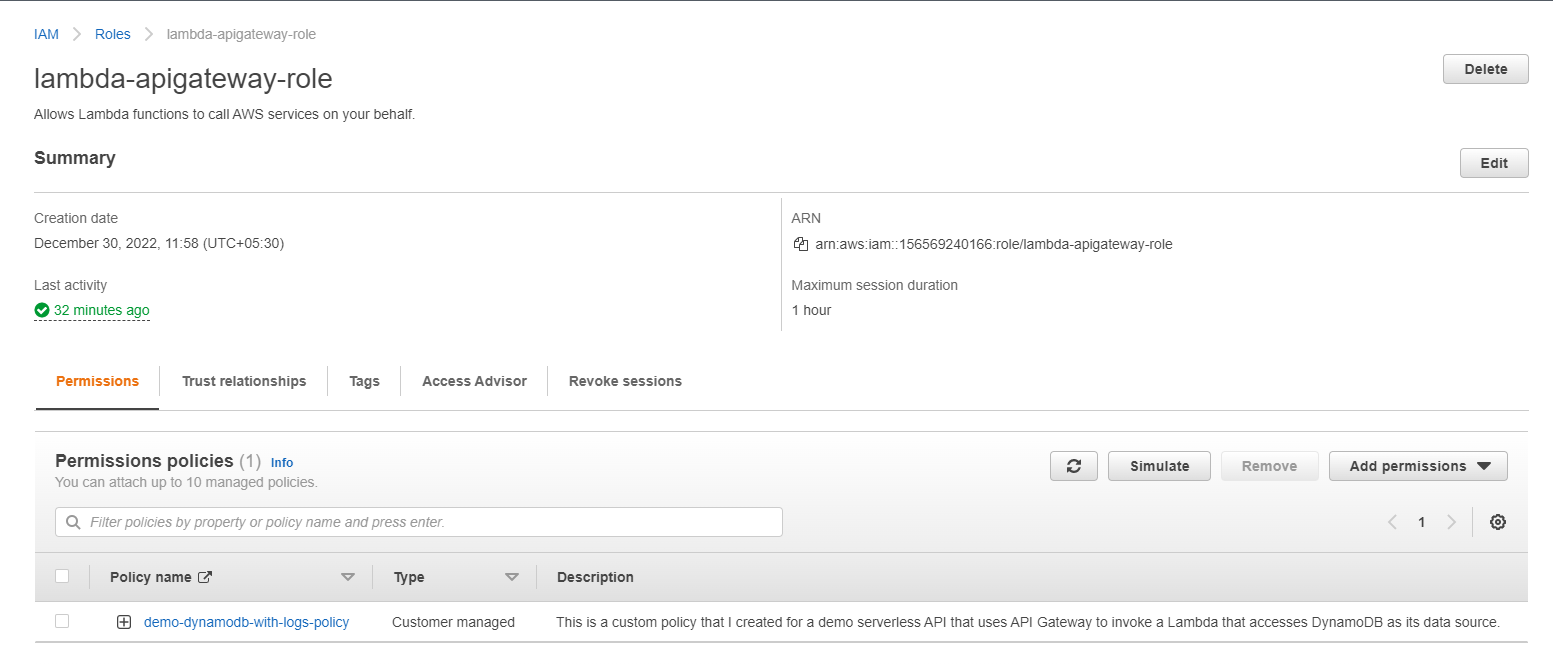

    - Role name : lambda-apigateway-role

## Create Lambda Function

#### To create the function

    1. Click "Create a Function" in AWS Lambda Console.
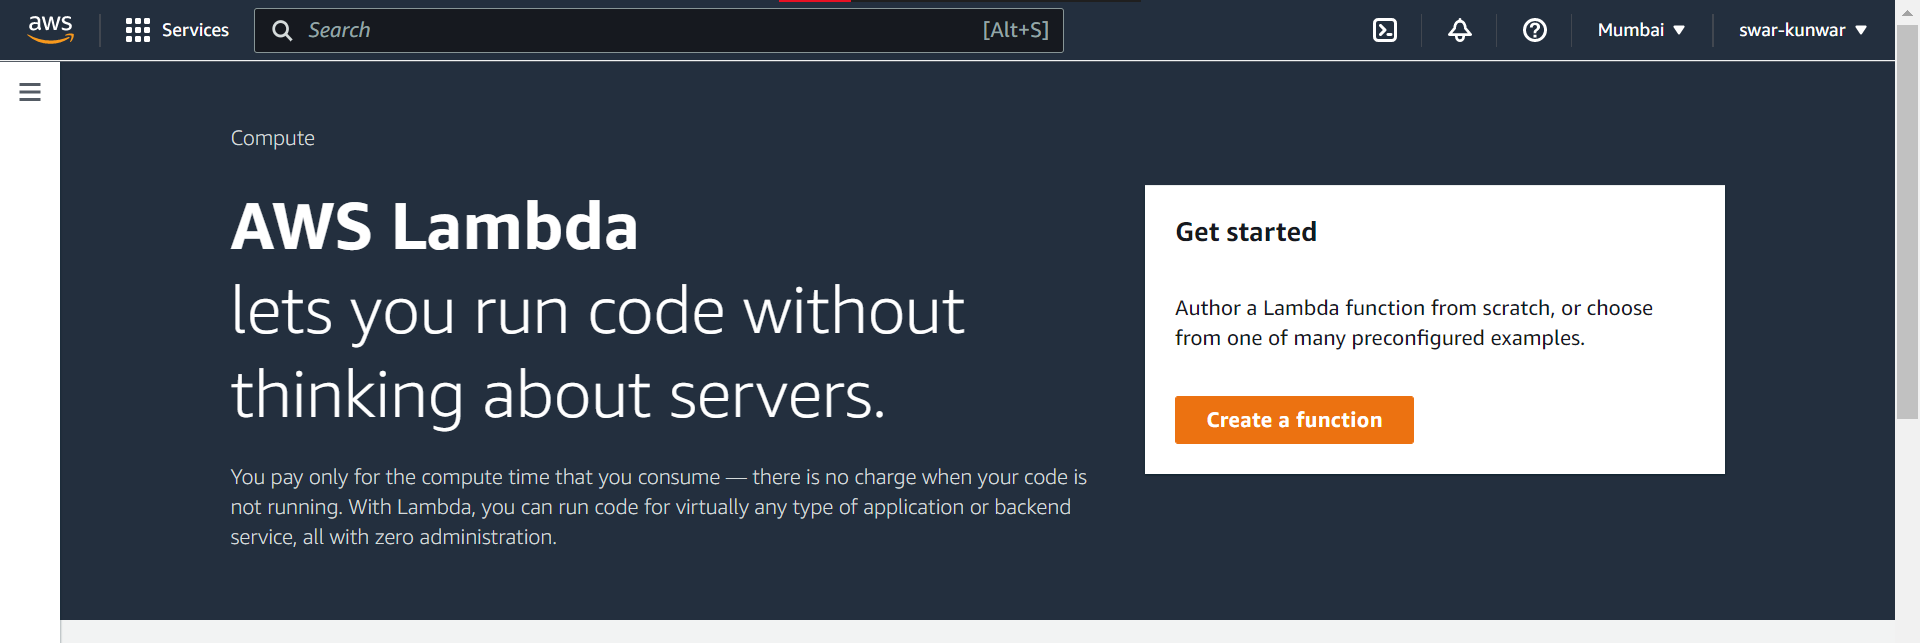
    
    2. Select "Author from scratch". Use name lambdaFunctionOverHttps , select Python 3.7 as Runtime. 
       Under Permissions, select "Use an existing role", and select lambda-apigateway-role that we created,
       from dropdown. 
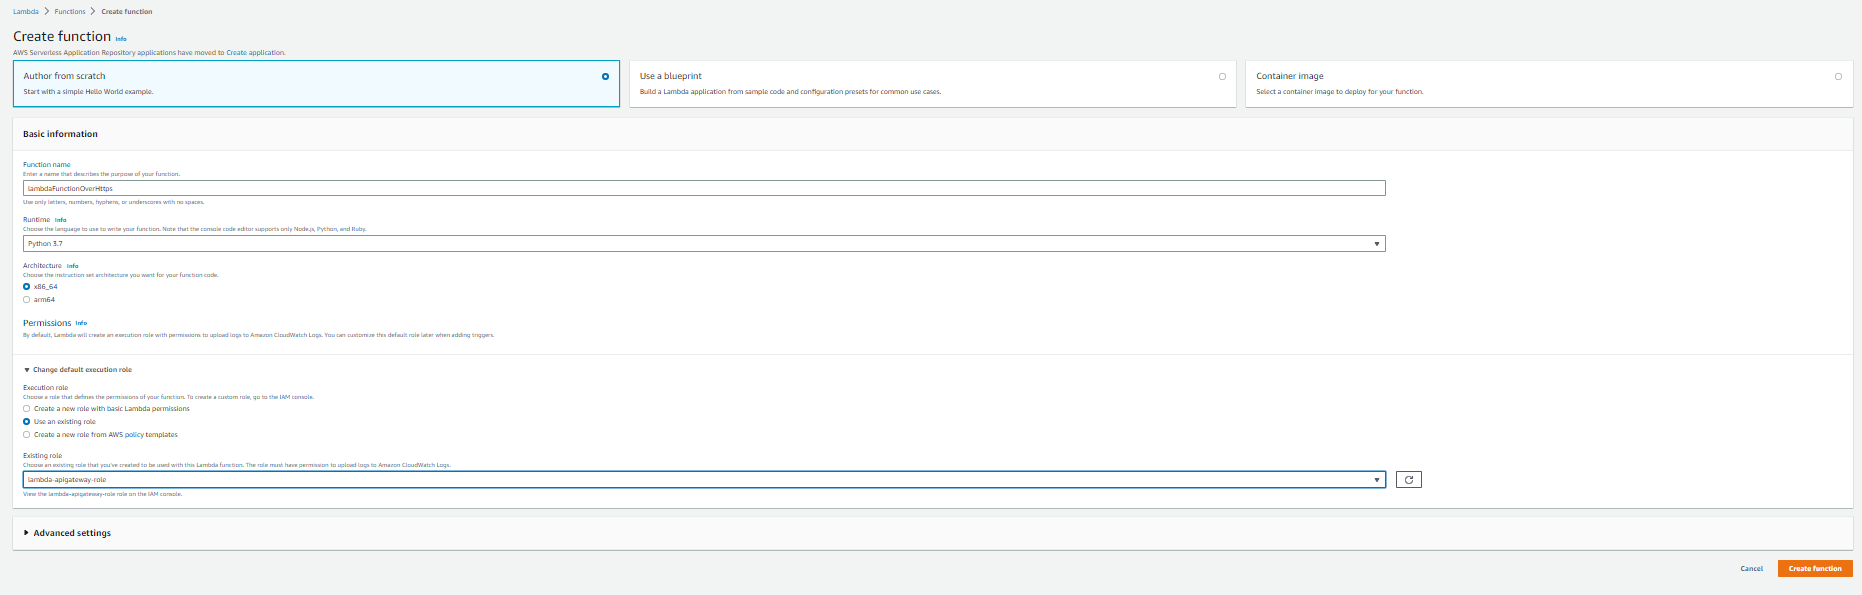
    
    3. Click "Create function".
    
    4. Replace the boilerplate coding with the following snippet and click "Save".

# The Lambda function for serverless CRUD operations λ 

In [13]:
from __future__ import print_function

import boto3
import json

print('Loading function')

def lambda_handler(event, context):
    '''Provide an event that contains following keys:
    
        - operation   :  one of the operation in the the operation dict below
        - tableName :    required for operations that interact with DynamoDB
        - payload    :   a parameter to pass to the operation being performed
    '''
    
    operation = event['operation']
    
    if 'tableName' in event['operation']:
        dynamo = boto3.resource('dynamodb').Table(event['tableName'])
    
    #set of operations
    operations = {
        'create': lambda x: dynamo.put_item(**x),
        'read'  : lambda x: dynamo.get_item(**x),
        'update': lambda x: dynamo.update_item(**x),
        'delete': lambda x: dynamo.delete_item(**x),
        'list'  : lambda x: dynamo.scan(**x),
        'echo'  : lambda x: x,
        'ping'  : lambda x: 'pong'
    }
    
    if operation in operations:
        return operations[operation](event.get('payload'))
    else:
        raise ValueError('Unrecognized operation "{}"'.format(operation))
                                      

Loading function


## Test Lambda Function 

### Let's try our newly created function. We haven't created DynamoDB and the API yet, so we'll do a sample echo operation. The function should output whatever input we pass.

    1. Select "Test".
    2. Paste the following JSON into the event. 

```python
 {
     "operation": "echo",
     "payload": {
             "somekey1":"somevalue1",
             "somekey2":"somevalue2"
         }
 } 
```

> The field "operation" dictates what the lambda function will perform. 

> In this case, it'd simply return the payload from input event as output.

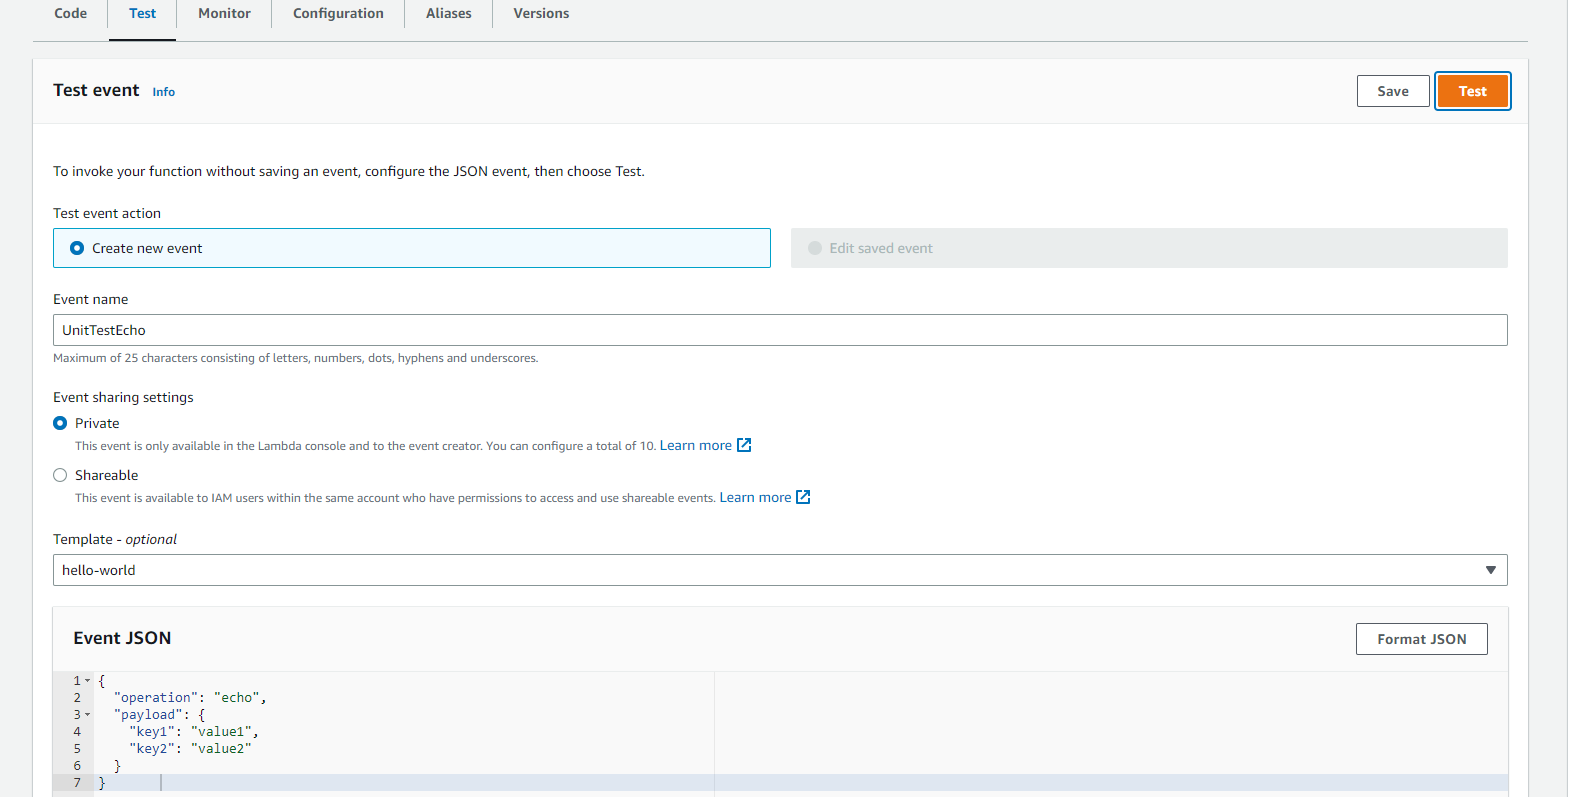

     3. Click "Test", and it will execute the test event. You should see the output in the console.
 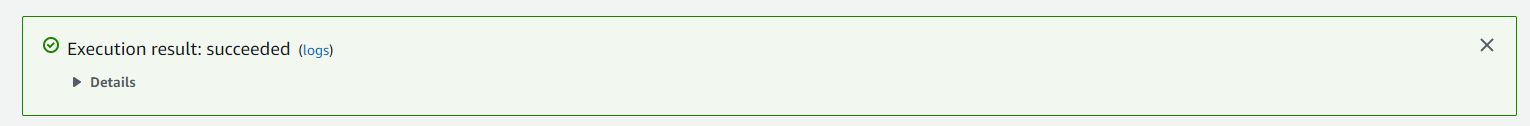

We're all set to create DynamoDB table and an API using our lambda as backend!

## Create DynamoDB Table

Create the Dynamo table that the Lambda function uses.

### To create a DynamoDB Table

    1. Open the DynamoDB console. 
    
    2. Choose "Create table".
    
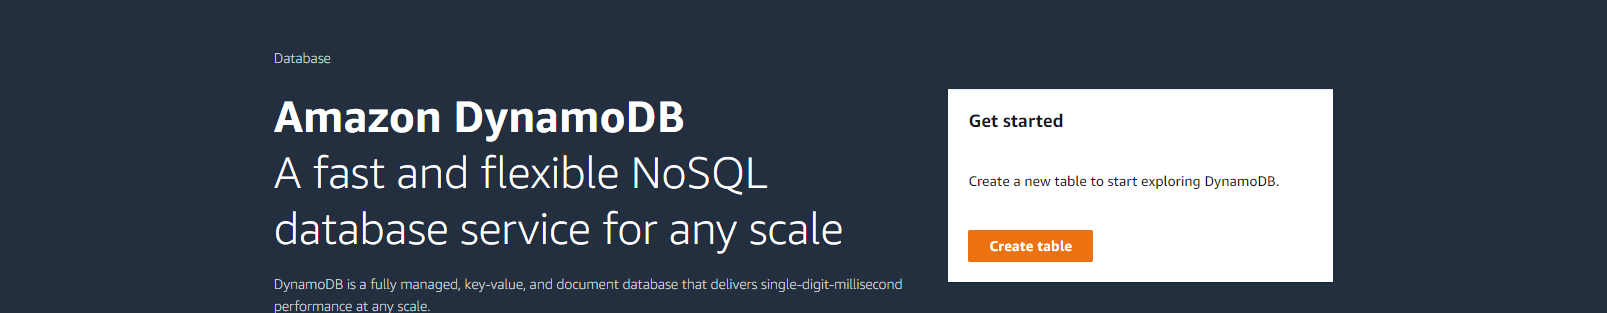

    3. Create a table with following settings.
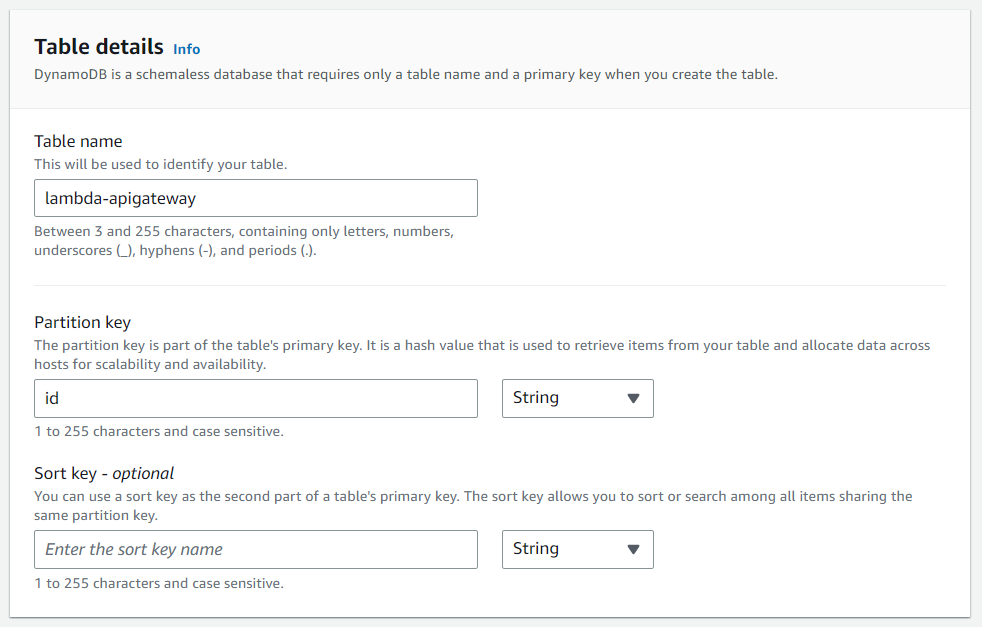

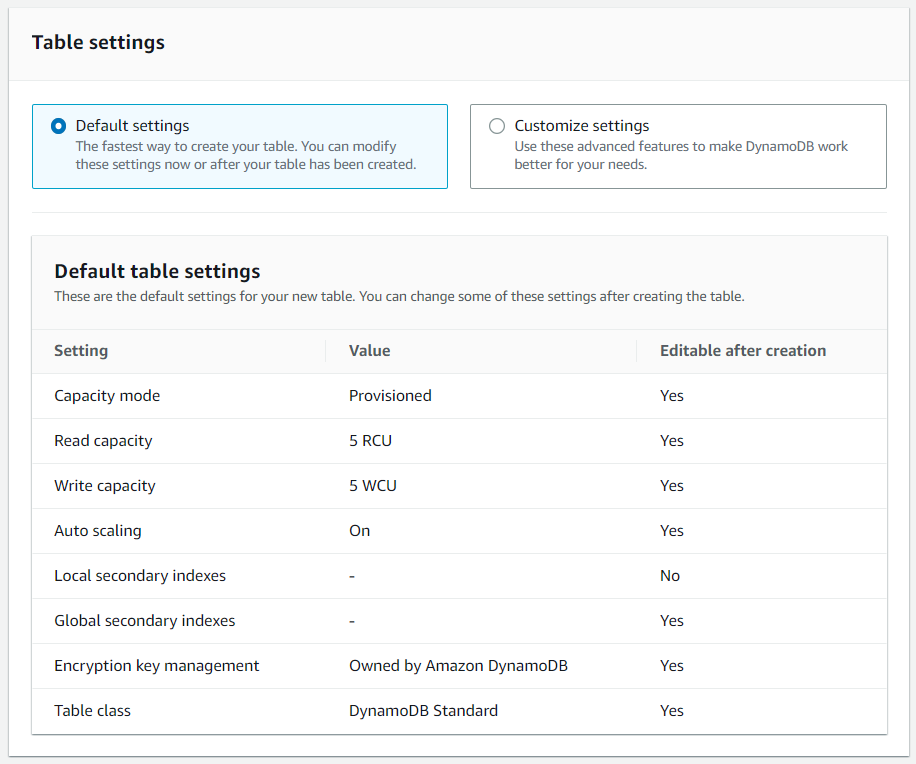

    4. Choose Create.

# Create API 

### To create the API 
    1. Go to API Gatway Console.
    
    2. Select the REST API complete request and response option that supports API documentation via for e.g. Postman,               Swagger etc. and click "Build".
    
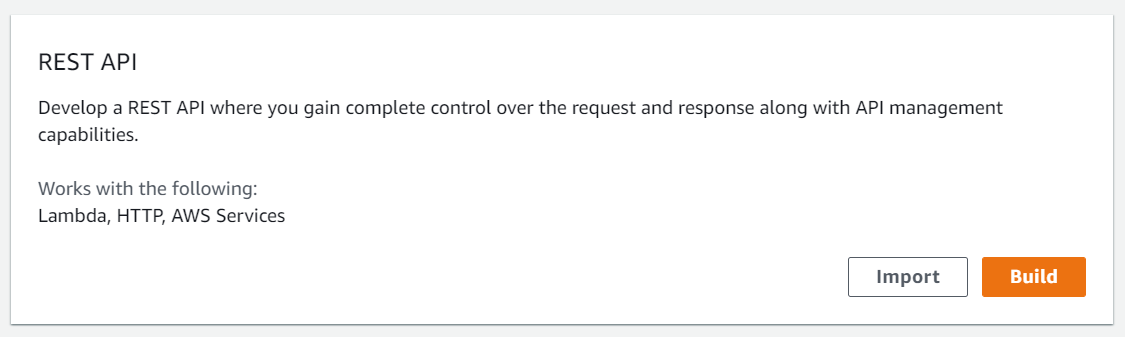    

3. Create resource as shown below.

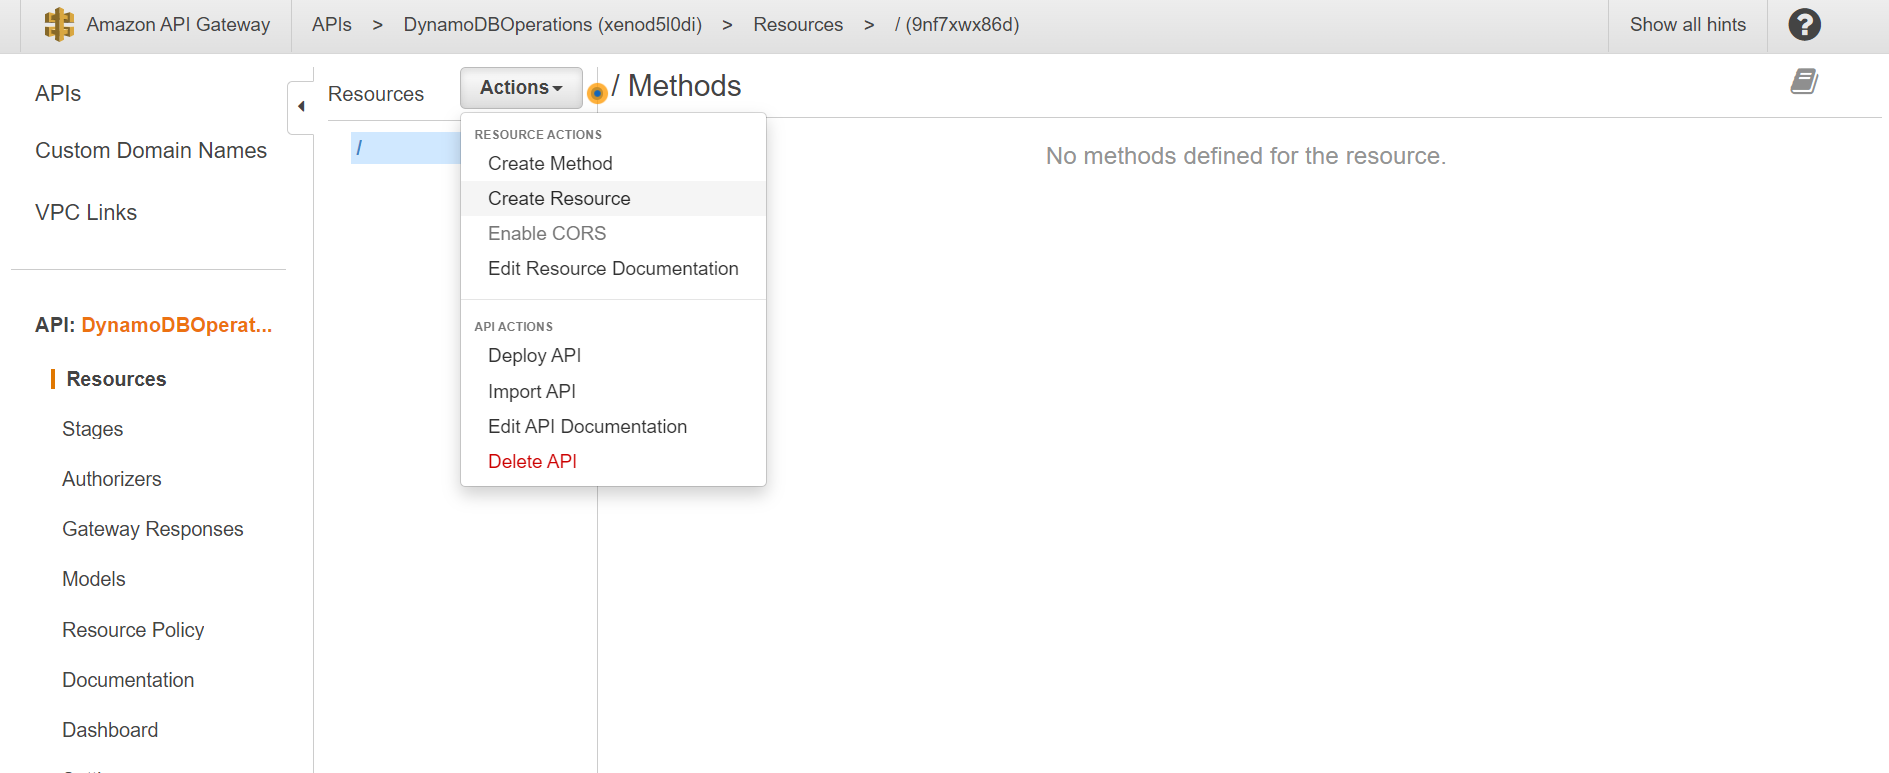

    4. Choose POST method for the created resource via "Actions" using "Create method" option.
    
    4.1
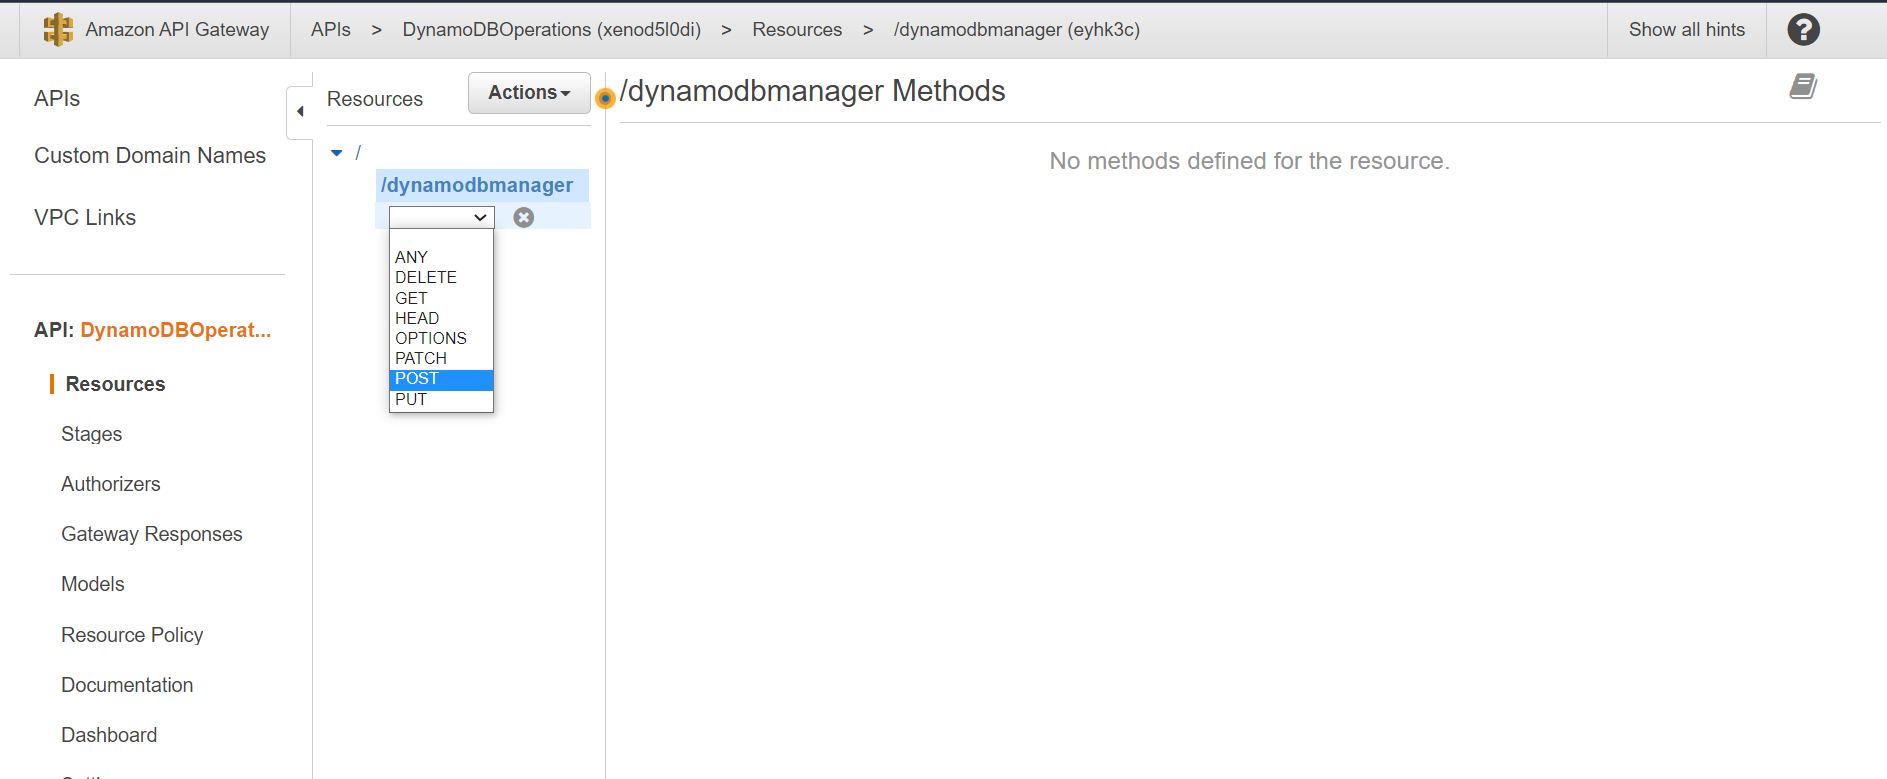

    4.2  The integration will come up automatically with "Lambda Function" option selected. 

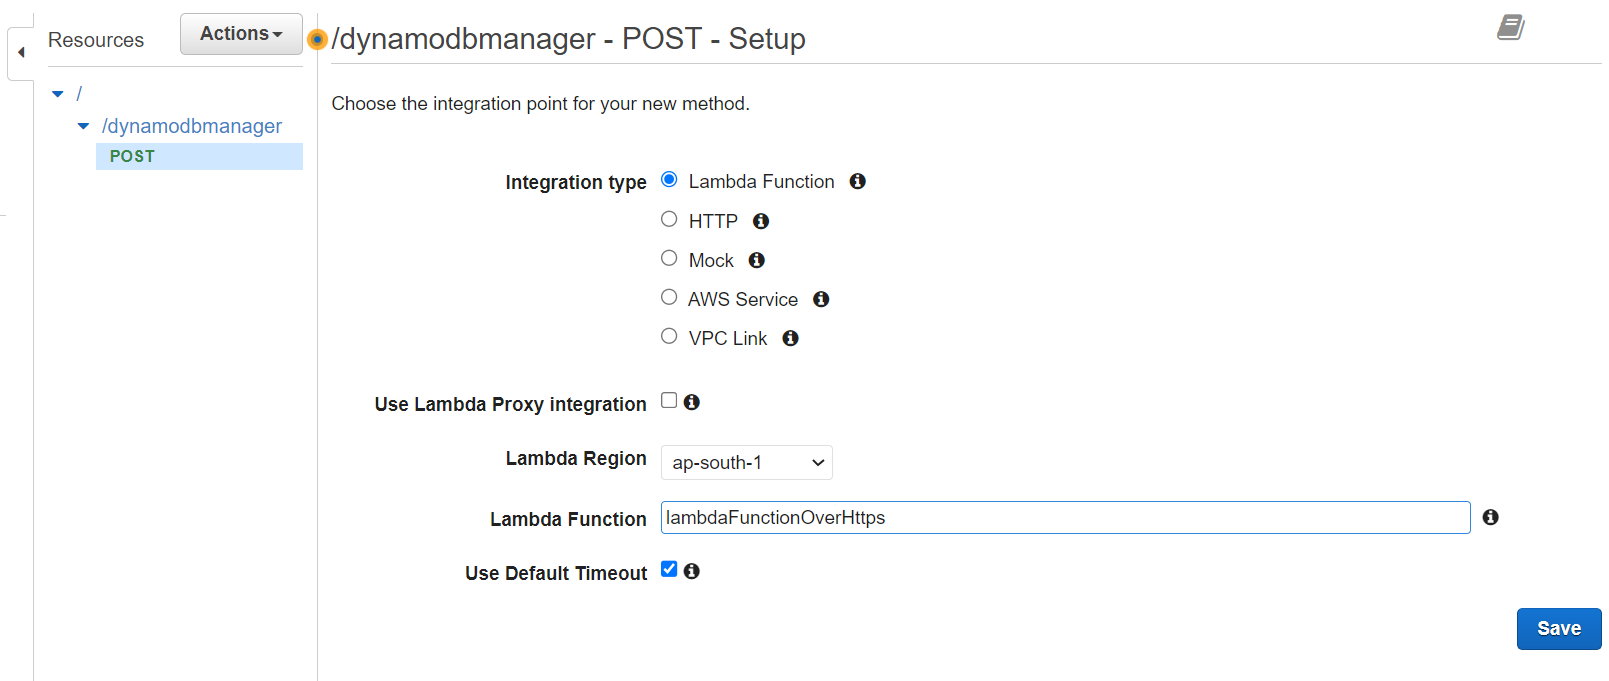

    4.3 Select "LambdaFunctionOverHttps" function that we created earlier. 
        As you start typing the name, your function name will show up.
        Select and click "Save". 
        A popup window will come up to add resource policy to the lambda to be invoked by this API. Click "Ok".

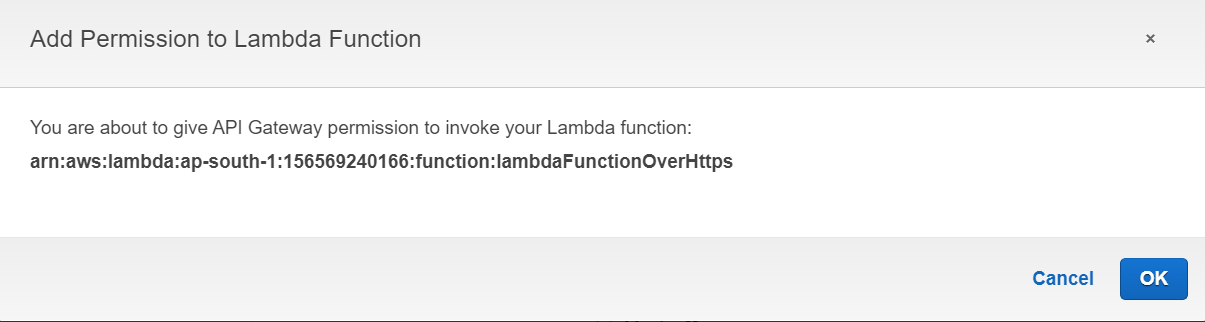

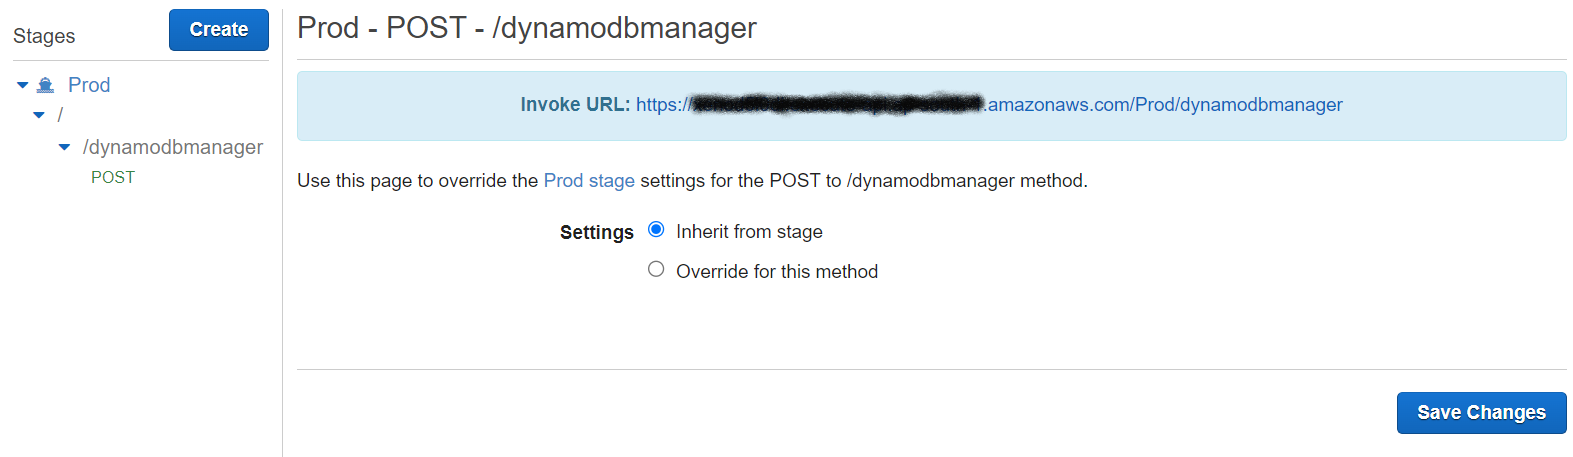

    2. Click Create API
    
    3. Scroll down and select "Build" for REST API
    4. Give the API name as "DynamoDBOperations", keep everything as is, click "Create API"
    5. Each API is collection of resources and methods that are integrated with backend HTTP endpoints,
       Lambda Functions, or other AWS services. Typically, API resources are organized in a resources are
       organized in a resource tree according to the application logic. At this time you only have the root 
       resource, but let's add resource next.
    6. Click "Actions", then click "Create Resource"
    7. Let's create a POST method for our API. With the "/dynamodbmanger" resource selected, Click "Actions"
       again and click "Create Method".
    8. Select "POST" from drop down, then click checkmark.
    9. The integration will automatically with "Lambda Fucntion" option selected. Select "LambdaFunctionOverHttps"
       function that we created earlier. As you start typing the name will show up. Select and click "Save".
       A pop-up window will come up to add resource policy to the lambda to be invoked by this API. Click "Ok".

Our API-Lambda integration is done!

## Deploy the API 

In this step, you deploy the API that you created to a stage called prod.

   

    3. We're all set to run our solution! To invoke our API endpoint, we need the endpoint url. In the "Stages" screen,
       expand the stage "Prod", select "POST" method, and copy the "Invoke URL" from screen

    1. Click "Actions", select "Deploy API".

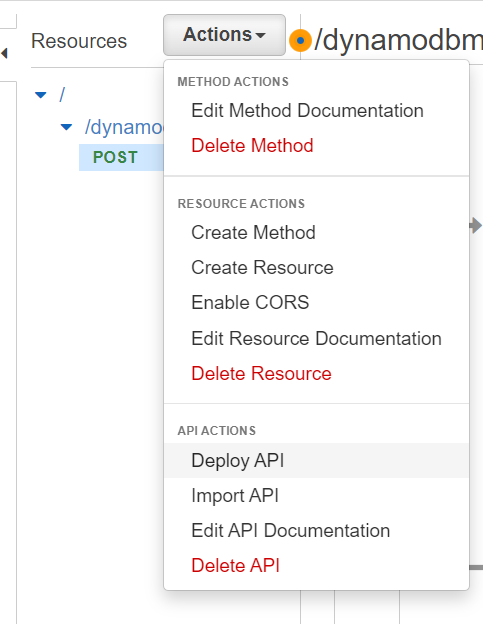


    2. Now it is going to ask you about a stage. Select "[New Stage]" for "Deployment Stage". Give "Prod" as "Stage name".
       Click "Deploy".

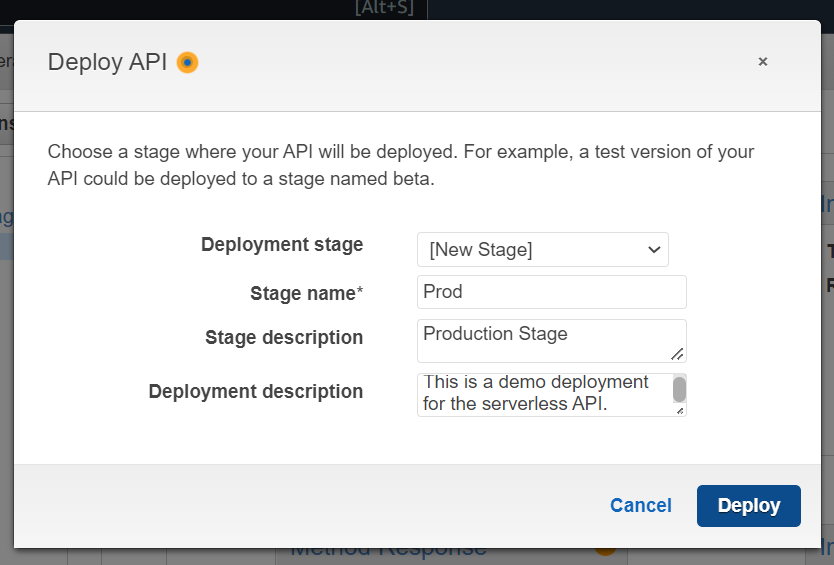

### Running our solution

    1. To execute our API from local machine, we are going to use Postman and Curl command.
    
    2. Firstly, we can do a ping test by sending the following as JSON body.
         - to run this from Postman, select "POST", paste the API invoke URL. Then under "Body" select "raw" and paste
           the below JSON.
           Click "Send". API should execute and return "HTTPStatusCode" 200.
    
    
```python
        {
        "operation": "ping"
        }           
```

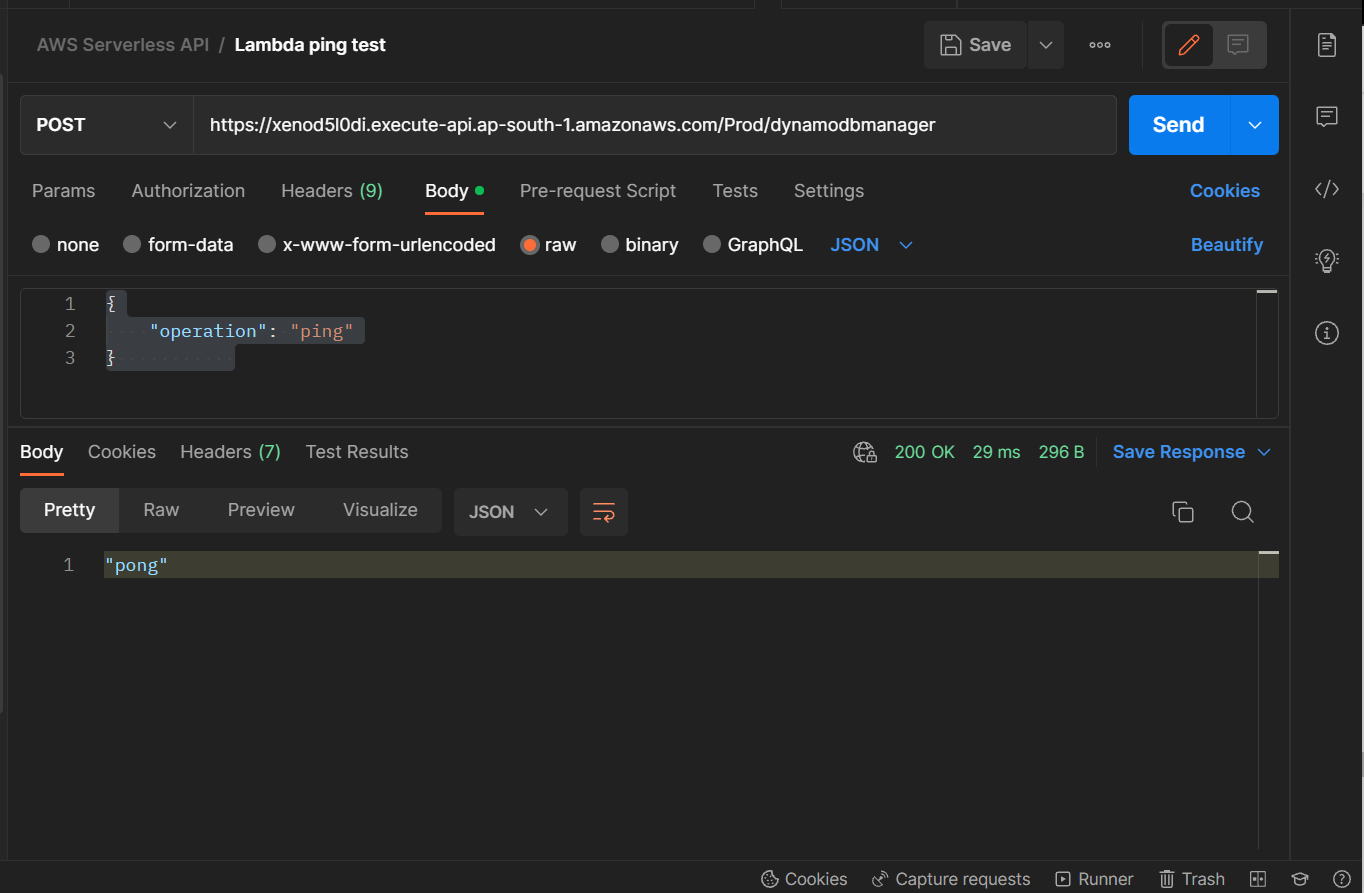

       3. "create" operation will create an entry with all specified item keys and values.

```python
        {
            "operation": "create",
            "tableName": "lambda-apigateway",
            "payload": {
                "Item": {
                    "id": "1",
                    "name": "Bob"
                }
            }
        }
```

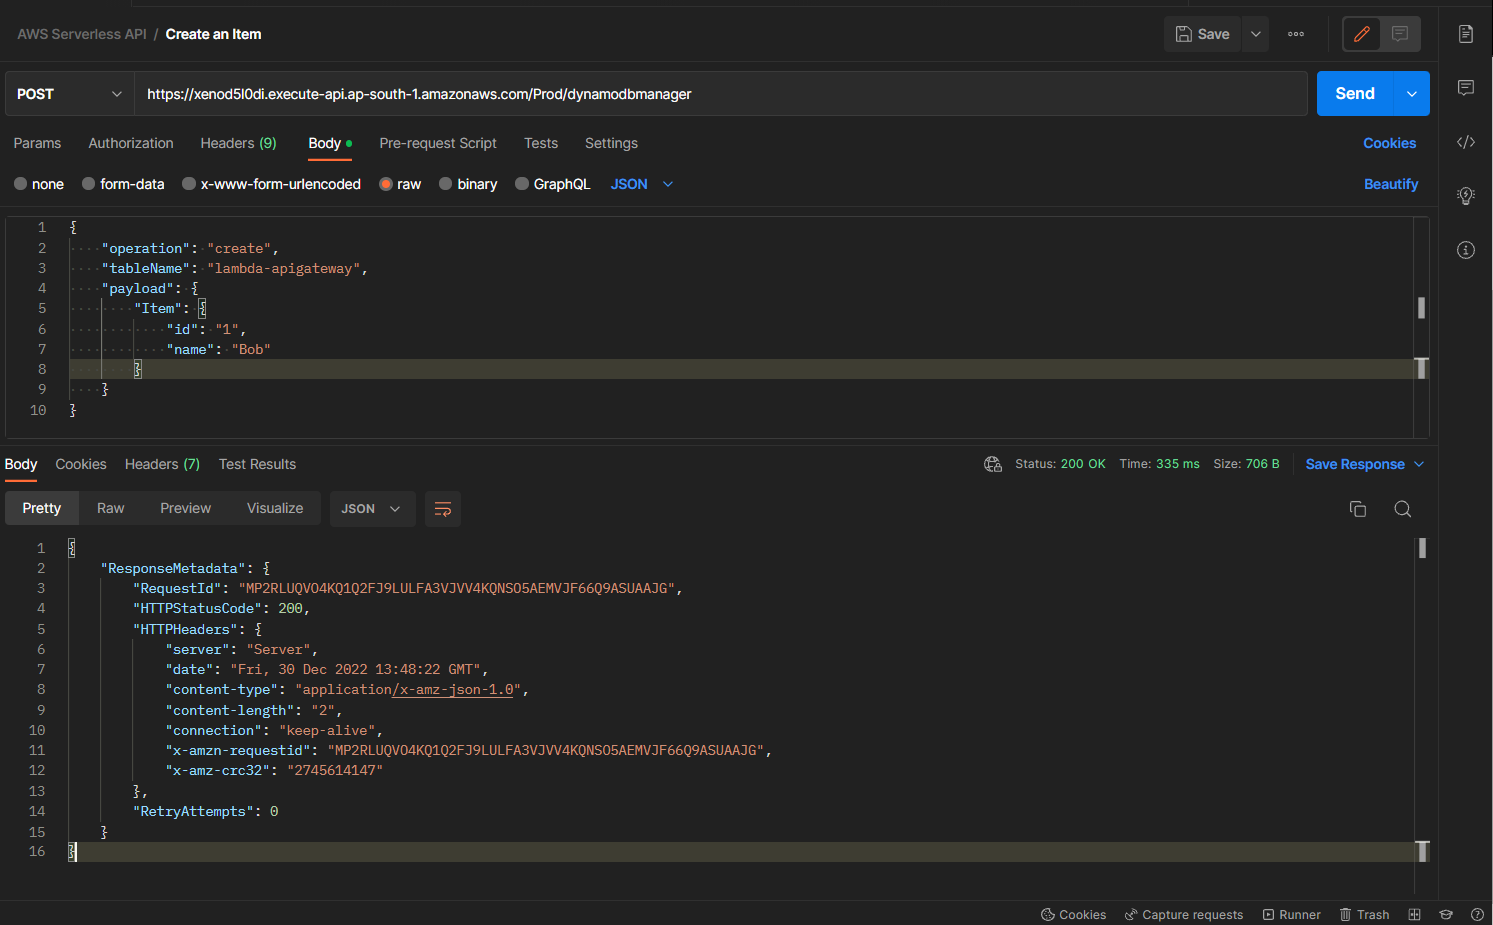

      4. To validate that the item is indeed inserted into DynamoDB table, go to Dynamo console,
         select "Items" tab, and the newly inserted item should be displayed.
         
 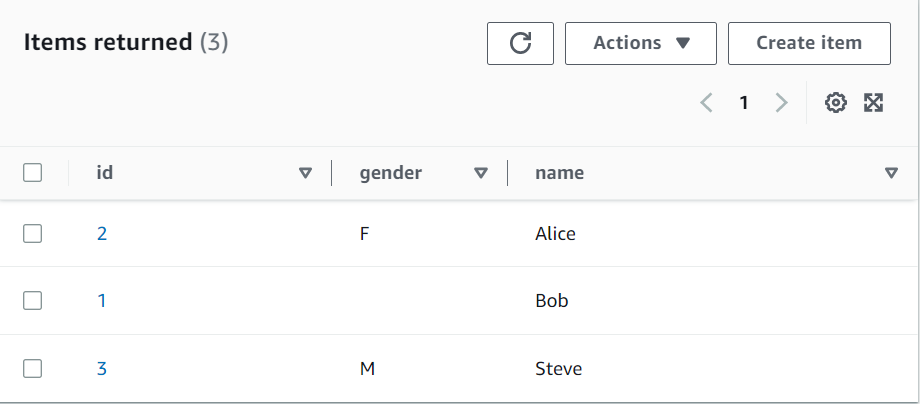

    5. According to the lambda written the read operation will commence as such using the following JSON body.
    
```python
    {
     "operation": "read",
     "tableName": "lambda-apigateway",
     "payload": {
          "Key": {
             "id":"4"
           }
     }         
     }
```
    
   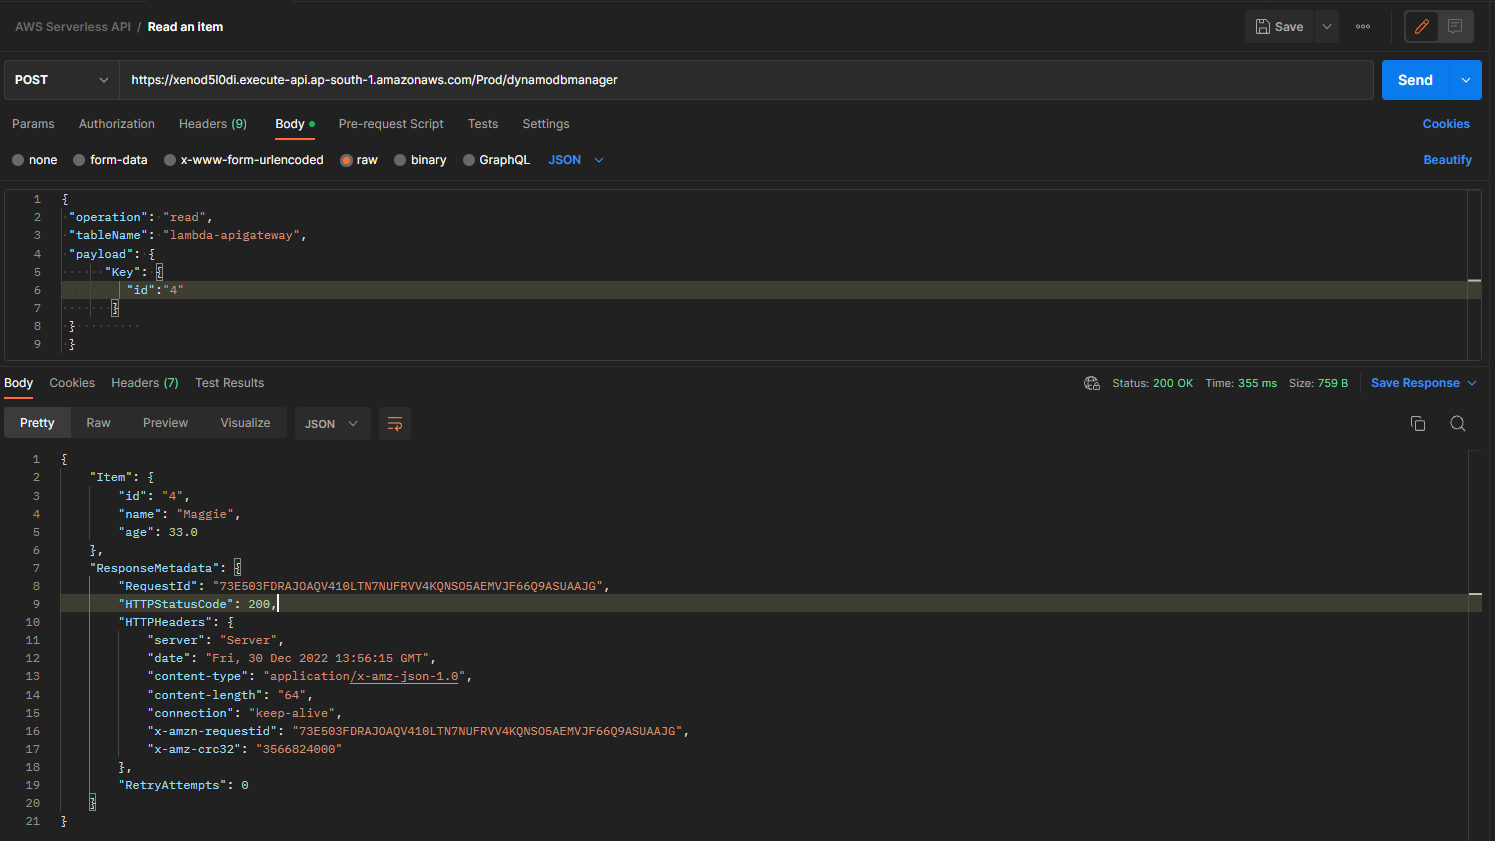

    6. When updating an item we have to mention "AttributeUpdates" along with the "Key" into the payload so that it updates the following item accordingly.
    
```python   
    {
        "operation": "update",
        "tableName": "lambda-apigateway",
        "payload": {
            "Key": {
                "id": "1"
                },
            "AttributeUpdates" : {    
                "gender": {
                    "Value":"M"
                },
                "age":{
                    "Value": 22
                }
            }
        }
    }
```
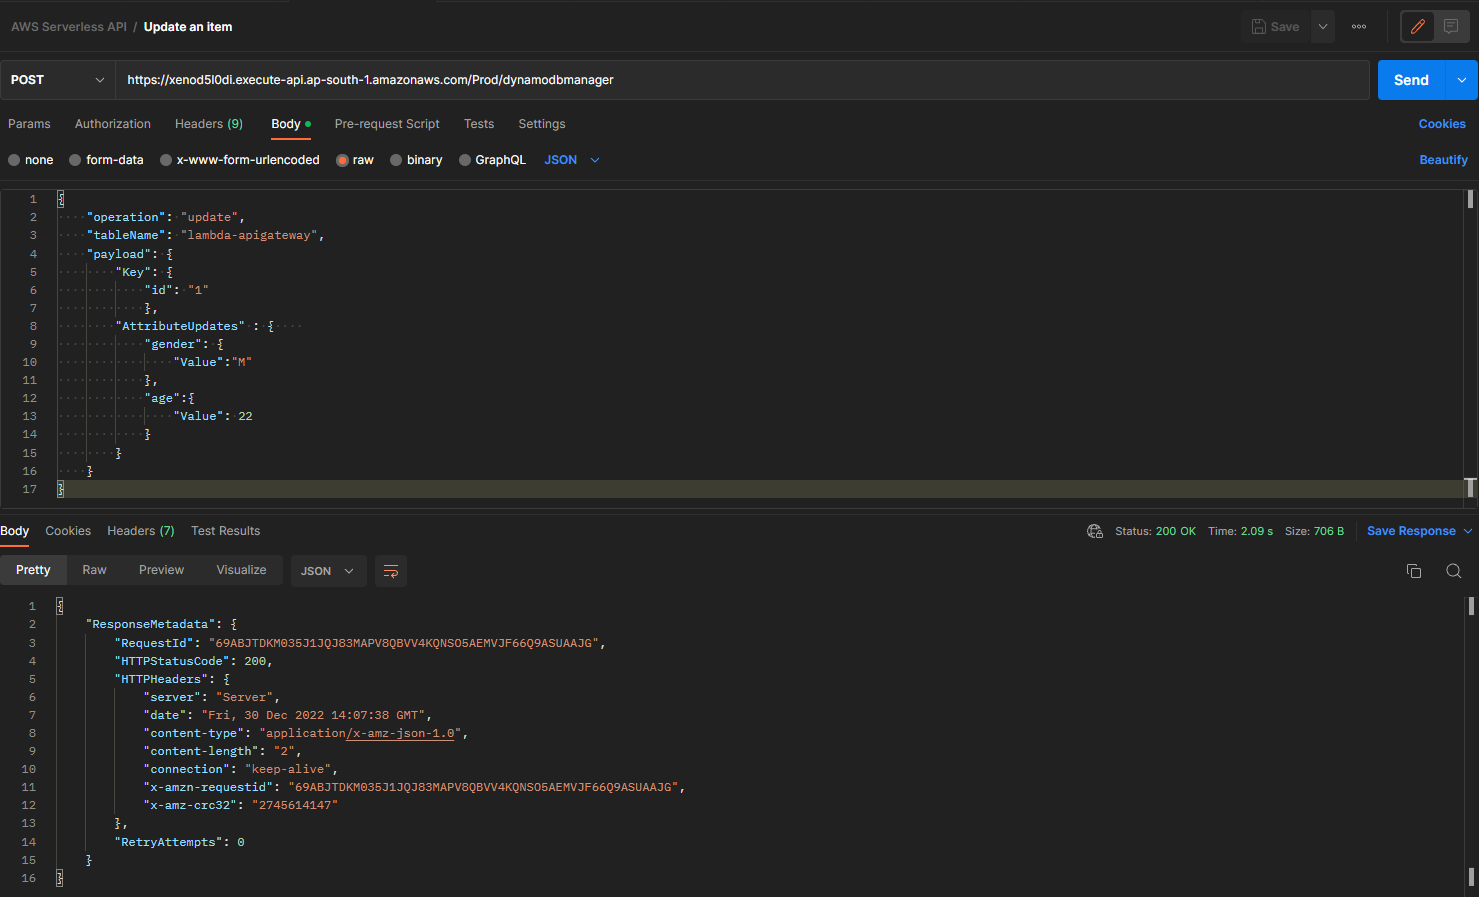

    7. Deleting an item is quite simple.

```python
    {
    "operation": "delete",
    "tableName": "lambda-apigateway",
    "payload": {
            "Key": {
               "id": "1"
              }
       }
   }       
```

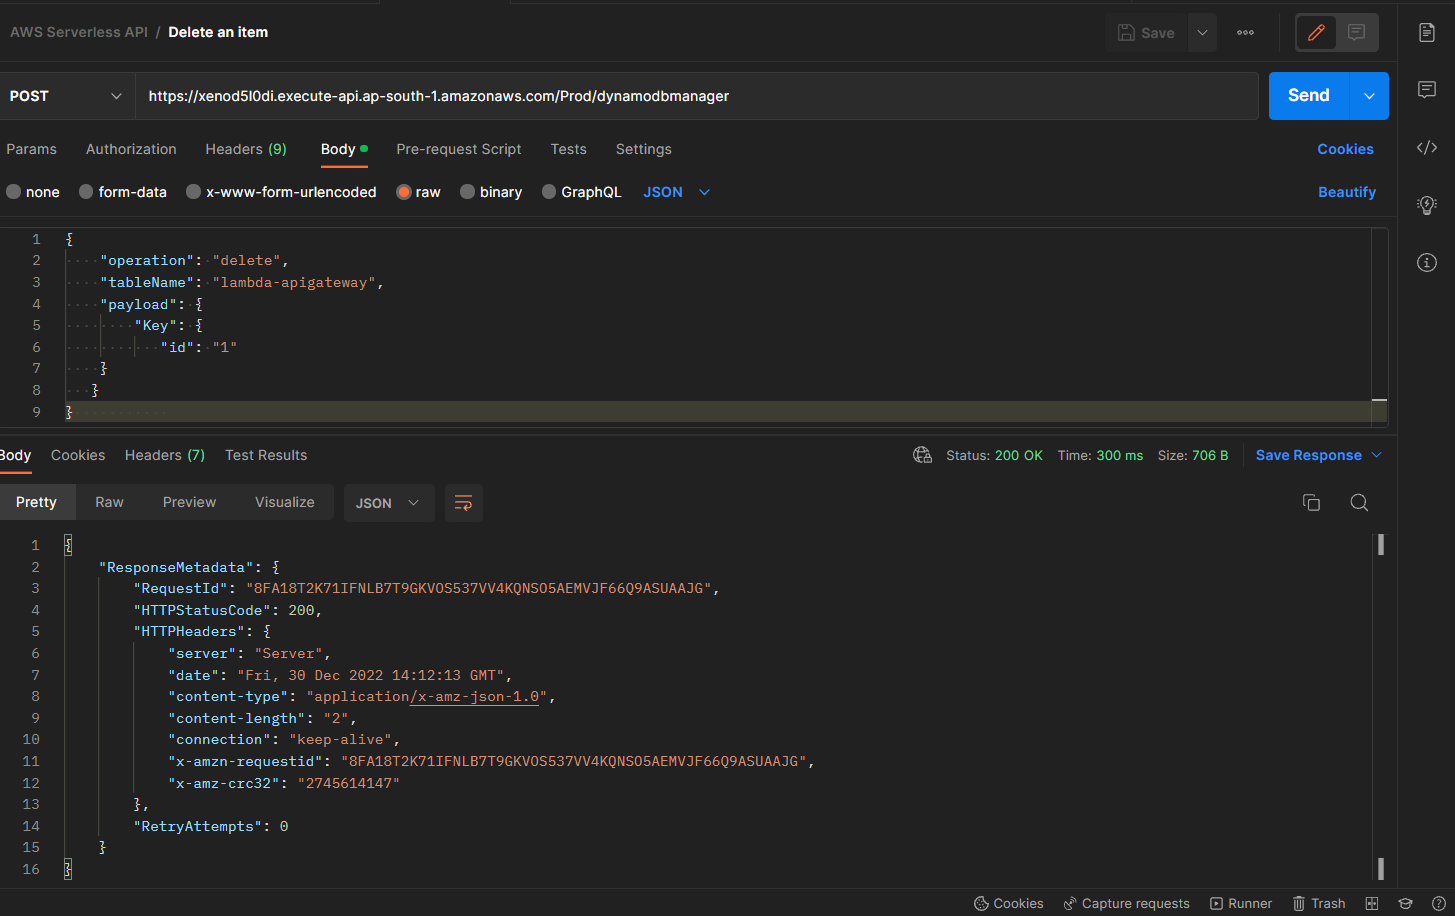

      ?. To get all the inserted items from the table, we can use the "list" operation of Lambda using the same API, and             it will return all the items from the Dynamo table.
    
```python
     {
         "operation":"list",
         "tableName":"lambda-apigateway",
         "payload":{
         }
     }
```

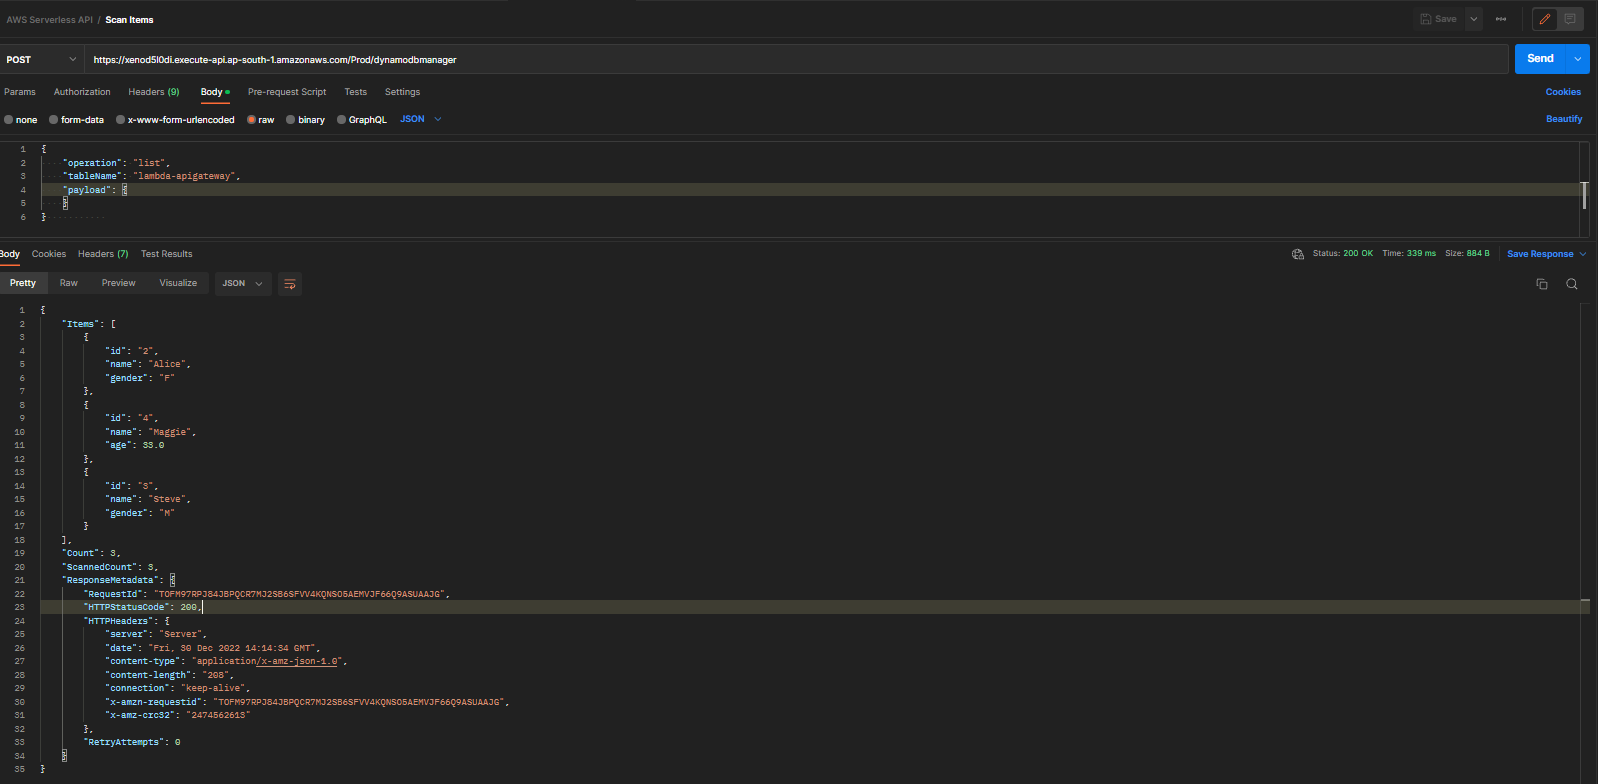

We have successfully created a serverless API using API Gateway, Lambda and DynamoDB!

# Cleanup 🗑

Let's clean up the resources we have created for this lab.

## Cleaning up DynamoDB

- To delete the table, from DynamoDB console, select the table "lambda-apigateway", and click "Delete table".

## Cleaning up Lambda
    
- To delete the lambda, from the Lambda console, select "LambdaFunctionOverHttps", click "Actions", 
    then click Delete.
    
## Cleaning up API

- To delete the API we created, in API gateway console, under the API select "DynamoDBOperations",
    click "Actions", then "Delete".